In [1]:
import pandas as pd
import os
import neurokit2 as nk
import numpy as np
from scipy import signal as sg
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
import pywt

In [2]:
Hz = 250
healthy_root = 'dataset/healthy_subset_ecg_data/'
rr_healthy_dataset = "rr_healthy.csv"
diabetes_root = 'dataset/diabetes_subset_ecg_data/'
rr_diabetes_dataset = "rr_diabetes.csv"

In [3]:
example = pd.read_csv("dataset/diabetes_subset_ecg_data/001/sensor_data/2014_10_01-10_09_39/2014_10_01-10_09_39_ECG.csv")["EcgWaveform"][15*Hz*60:].to_numpy()

In [4]:
total_len = lambda sr, frq: sr.shape[0]/frq
def rescale(sr, frq, start=0):
    X = np.arange(start, start+total_len(sr, frq), 1/frq)
    return (X, np.arange(len(X)))

def plot_signal(signals, ticks, size=(30, 10), itv=None, stem=False):
    for title in signals:
        fig, ax = plt.subplots()
        signal = signals[title]
        y_axis = signal["y"]
        x_axis, ind = (signal["x"], np.arange(len(signal["x"]))) if "x" in signal else rescale(y_axis.iloc[:,0], signal["rate"])
        if itv is not None:
            ind = ind[((x_axis >= itv[0]) & (x_axis <= itv[1]))]
        
        ax.grid(True)
        if stem:
            ax.stem(x_axis[ind], y_axis.iloc[ind], label=(y_axis.columns if len(y_axis.columns) > 1 else y_axis.columns[0]), markerfmt=' ')
        else:
            ax.plot(x_axis[ind], y_axis.iloc[ind], label=(y_axis.columns if len(y_axis.columns) > 1 else y_axis.columns[0]))
        
        if "labels" in signal:
            x_lbls = signal["labels_ind"]
            filter_ = (x_lbls >= ind[0]) & (x_lbls <= ind[-1])
            x_lbls = x_lbls[filter_]
            y_lbls = signal["labels"][filter_]
            lbls = np.unique(y_lbls)
            for lbl in lbls:
                ind_l = x_lbls[y_lbls == lbl]
                ax.plot(x_axis[ind_l], y_axis.iloc[ind_l], "X", label=lbl)
        
        # Size
        fig.set_figwidth(size[0])
        fig.set_figheight(size[1])
        
        # Labels
        plt.xlabel(ticks[0])
        plt.ylabel(ticks[1])
        
        plt.title(f'{title} [rate={("rate" in signal and signal["rate"]) or "?"}Hz; len={x_axis[-1]}s]')
        plt.legend()
        plt.show()

In [25]:
def my_qrs_detector(mwa_norm, original, fs, verbose=False):
    total_time = int(len(mwa_norm)/fs)
    delta      = 10
    scale      = 1.2
    RESCALING  = False
    BEATLESS_MAX = 2
    MISSED_MIN_AMP = 0.005
    MISSED_MAX_AMP = 0.1
    
    lstage     = 10
    dstage     = 3
    
    dstages = int((total_time-lstage)/dstage)
    stages = [int(lstage*fs), *[int(dstage*fs) for _ in range(dstages)]]
    if (sum(stages) < len(mwa_norm)):
        stages += [len(mwa_norm) - sum(stages)]

    is_peak = lambda loc, dt: (mwa_norm[loc-dt:loc] < mwa_norm[loc]).all() and (mwa_norm[loc+1:loc+1+dt] < mwa_norm[loc]).all()
    
    config = {
        "Fs":         fs,
        "pk_mwa":     [],
        "amp_vec":    [],
        "ppi_vec":    [],
        "amp_thr":    .20,
        "ppi_thr":    int(.3*fs),
        "missed_ppi": None,
        "sd_rr5":     None,
        "r_vec":      []
    }
    
    # helpers
    def get_sd5(vec):
        return np.std(np.diff(vec[-6:]))
    
    def ppi_inner(pair, b, e, inn, edge=None):
        x_2 = e
        x_1, val = pair
        x_0 = b if not inn else inn[-1]["loc"]
        
        l_ppi, r_ppi = np.diff([x_0, x_1, x_2])
        
        if edge is None:
            ppi=min(l_ppi, r_ppi)
        else:
            ppi=l_ppi
        
        return {"l_ppi": l_ppi, "r_ppi": r_ppi, "ppi": ppi, "loc": x_1, "amp":val}
    
    def ins_pk(dst, src, pos):
        for el in reversed(src):
            dst.insert(pos+1, el["loc"])
    
    def ins_amp(dst, src, pos):
        for el in reversed(src):
            dst.insert(pos+1, el["amp"])
    
    def ins_ppi(dst, src, pos):
        if not src:
            return
        dst[pos] = src[-1]["r_ppi"]
        for el in src:
            dst.insert(pos, el["l_ppi"])
    
    # steps
    def tbased_peak_detection(signal, start, end, cf):
        delta = 3
        
        window_b = start + delta
        window_e = end - delta
        
        # 2
        for loc in range(window_b+delta, window_e-delta):
            
            val = signal[loc]
            if not is_peak(loc, delta):
                continue

            if val > cf["amp_thr"] and ( not len(cf["pk_mwa"]) or loc-cf["pk_mwa"][-1] > cf["ppi_thr"] ):
                cf["pk_mwa"] += [loc]
                
        # 3
        for loc in cf["pk_mwa"]:
            cf["amp_vec"] += [ signal[loc] ]

        # 4
        if len(cf["r_vec"]) != 0:
            cf["ppi_vec"] += list(np.diff([ cf["r_vec"][-1] ] + cf["pk_mwa"] + [ window_e ]))
        else:
            cf["ppi_vec"] += list(np.diff([ window_b ] + cf["pk_mwa"] + [ window_e ]))
        
        
    
    def missed_beat_detection(signal, start, end, cf):
        window_b = start + delta
        window_e = end - delta
        missed_itv = []
        
        if cf["sd_rr5"] is None:
            cf["sd_rr5"] = np.std(cf["ppi_vec"][-5:]) 
        
        if (cf["sd_rr5"] > 0.1*cf["Fs"]):
            missed_thr = (1.25 * cf["ppi_thr"]) 
        else:
            missed_thr = (1.5 * cf["ppi_thr"])
        for loc, itv in enumerate(cf["ppi_vec"]):
            if itv > missed_thr:
                missed_itv += [loc]

        # 6
        missed_pk_vec  = [[] for _ in missed_itv]

        cf["missed_ppi"] = max(0.75*cf["ppi_thr"], (0.2*cf["Fs"]))
        for inner, ind_itv in zip(missed_pk_vec, missed_itv):
            if ind_itv == 0 and len(cf["ppi_vec"]) == 1:
                itv_b = window_b
                itv_e = window_e
            elif ind_itv == 0:
                itv_b = window_b
                itv_e = cf["pk_mwa"][ind_itv]
            elif ind_itv == len(cf["ppi_vec"])-1:
                itv_b = cf["pk_mwa"][ind_itv-1]
                itv_e = window_e
            else:
                itv_b = cf["pk_mwa"][ind_itv-1]
                itv_e = cf["pk_mwa"][ind_itv]
            
            local_thr = MISSED_MAX_AMP
            while True:
                segments = [itv_b]
                
                for loc in range(itv_b, itv_e):
                    if not is_peak(loc, delta):
                        continue
                    edge=None
                    if itv_e == window_e:
                        edge=True
                    info = ppi_inner((loc, signal[loc]) , itv_b, itv_e, inner, edge)
                    val = signal[loc]
                    if info["ppi"] > cf["missed_ppi"] and info["amp"] > local_thr:
                        inner += [info]
                        segments += [ loc ]
                
                segments += [ itv_e ]
                if not RESCALING:
                    break
                if len(inner) != 0 and np.diff(segments).max() < BEATLESS_MAX:
                    break
                elif ((itv_e-itv_b)/cf["Fs"]) < BEATLESS_MAX:
                    break
                elif local_thr < MISSED_MIN_AMP:
                    break
                
                inner.clear()
                local_thr /= scale

        # 7
        for inner, ind_itv in zip(reversed(missed_pk_vec), reversed(missed_itv)):
            ins_pk(cf["pk_mwa"], inner, ind_itv)
            ins_ppi(cf["ppi_vec"], inner, ind_itv)
            ins_amp(cf["amp_vec"], inner, ind_itv)
    
    def update_thresholds(signal, start, end, cf):
        if start == 0:
            cf["amp_thr"] = 0.4*(cf["amp_thr"]  + np.min(cf["amp_vec"]))
            cf["ppi_thr"] = 0.75*(cf["ppi_thr"]) + 0.25*(np.median(cf["ppi_vec"]))
        else:
            cf["amp_thr"] = 0.4*(cf["amp_thr"]  + np.min(cf["amp_vec"] ))
            cf["ppi_thr"] = 0.4*((cf["ppi_thr"]) + np.min(cf["ppi_vec"]))
    
    def r_peak_location(signal, start, end, cf):
        delta = 3
        real = []
        band = int(.15*cf["Fs"])
        
        window_b = start + delta
        window_e = end - delta
        
        # 9
        for loc in cf["pk_mwa"]:
            delta_r = window_e-loc if loc+band>window_e else band
            real += [loc+np.argmax(original[loc: loc+delta_r])]
        # 10
        if not real:
            real += [np.argmax(signal[window_b: window_e])]
        
        # 11
        cf["r_vec"] += real

        # 12
        last6 = np.diff(cf["r_vec"][-6:])
                               
        # 13
        cf["sd_rr5"] = np.std(last6)
        
        # cleanup
        cf["pk_mwa"].clear()
        cf["ppi_vec"].clear()
        cf["amp_vec"].clear()
    
    
    prv = 0
    for stage in stages:
        cur = prv+stage
        tbased_peak_detection(mwa_norm, prv, cur, config)
        missed_beat_detection(mwa_norm, prv, cur, config)
        r_peak_location(mwa_norm, prv, cur, config)
        prv = cur
    
    
    peaks = [el for el in config["r_vec"] if el < fs*total_time]
    if verbose:
        labeled = {
                "ECG (normalized MWA) labeled signal": {
                    "rate": fs,
                    "y": pd.DataFrame(mwa_norm, columns=["norm mwa"]),
                    "labels": np.array(['my']*len(peaks)),
                    "labels_ind": np.array(peaks),
                }
        }
        plot_signal(labeled, ("Second(s)", "Volt(s)"), size=(30, 10))

    return sorted(peaks)


def my_swt_detector(my_signal, fs, verbose=False):
    LVL = 2
    WINDOW_LEN = int(0.1*fs)
    
    
    duration = len(my_signal)//fs
    resampled = sg.resample(my_signal, duration*80)
    for padding in range(2**LVL):
        if ( (len(resampled)+padding)%2**LVL == 0 ):
            break
    # Implementation of swt requires 
    if padding:
        resampled = np.pad(resampled, (0, padding), 'edge')
    
    (cAn, cDn), *_  = np.array(pywt.swt(resampled, 'db7', LVL))
    cDn = sg.resample(cDn, duration*Hz)
    cDn_sq = np.square(cDn)
    
    # MWA
    MWA = np.convolve(cDn_sq, np.ones(WINDOW_LEN), 'valid')/WINDOW_LEN
    MWA = np.pad(MWA, (0, len(cDn_sq)-len(MWA)), 'edge')
    
    if verbose:
        source = {
            "Signal (with noice)": {
                "rate": fs,
                "y": pd.DataFrame(my_signal, columns=["original"])
            }
        }
        wavelet = {
            "Signal (after Wavelet)": {
                "rate": fs,
                "y": pd.DataFrame(cDn, columns=["wavelet"])
            }
        }
        wavelet_sq = {
            "Signal (Wavelet squred)": {
                "rate": fs,
                "y": pd.DataFrame(cDn_sq, columns=["wavelet^2"])
            }
        }
        mwa = {
            "Signal (MWA)": {
                "rate": fs,
                "y": pd.DataFrame(MWA, columns=["mwa"])
            }
        }

        plot_signal(source, ("Second(s)", "Volt(s)"), size=(30, 10))
        plot_signal(wavelet, ("Second(s)", "Volt(s)"), size=(30, 10))
        plot_signal(wavelet_sq, ("Second(s)", "Volt(s)"), size=(30, 10))
        plot_signal(mwa, ("Second(s)", "Volt(s)"), size=(30, 10))
    
    MWA_NORM = (MWA-np.min(MWA))/(np.max(MWA)-np.min(MWA))
    print("=START=")
    peaks = my_qrs_detector(MWA_NORM, my_signal, fs, verbose)
    print("=END=")
    return peaks

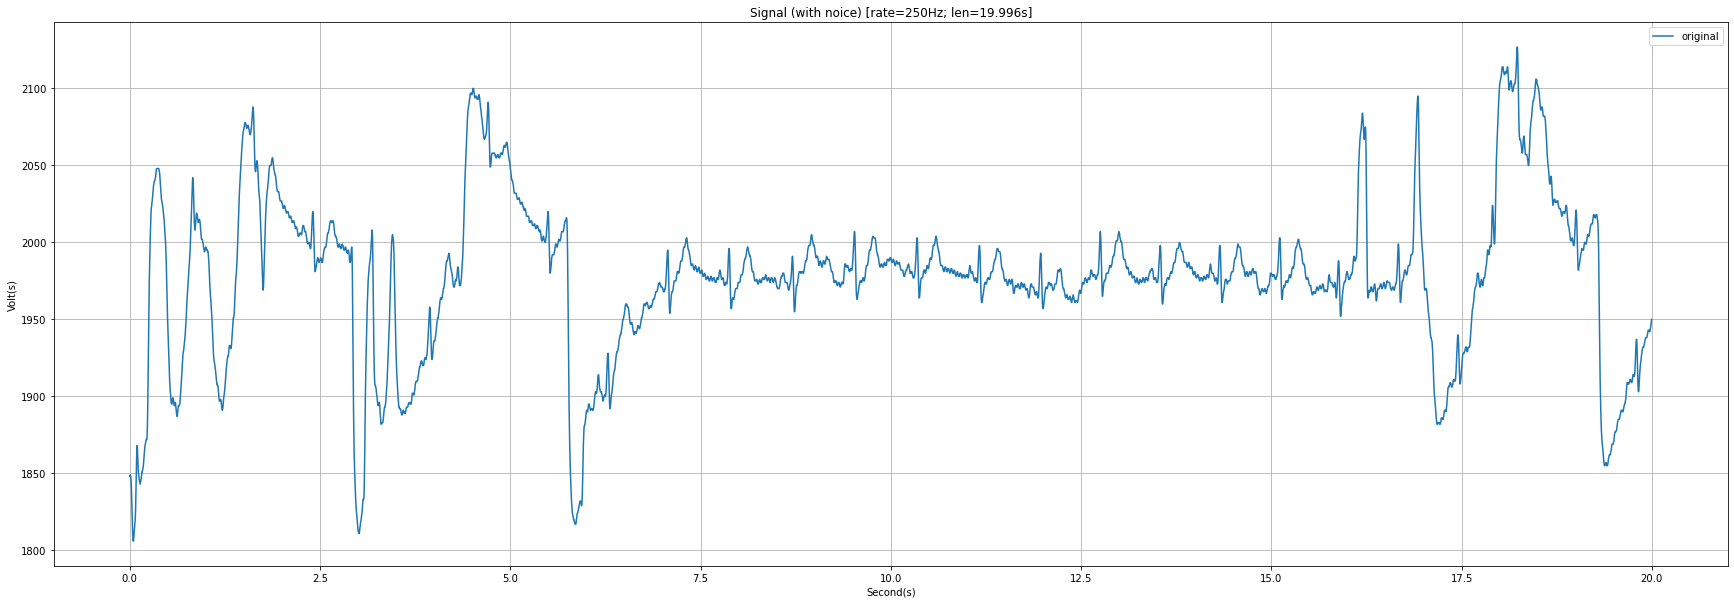

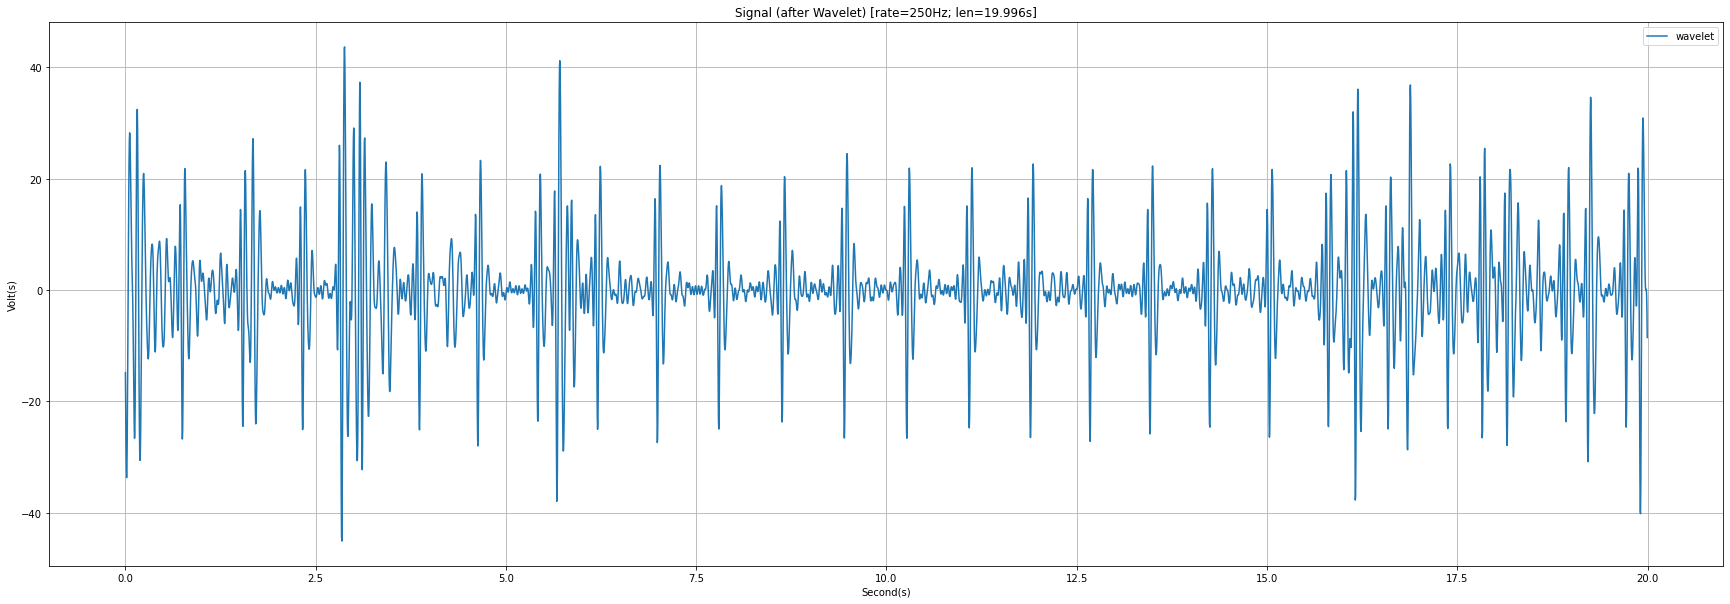

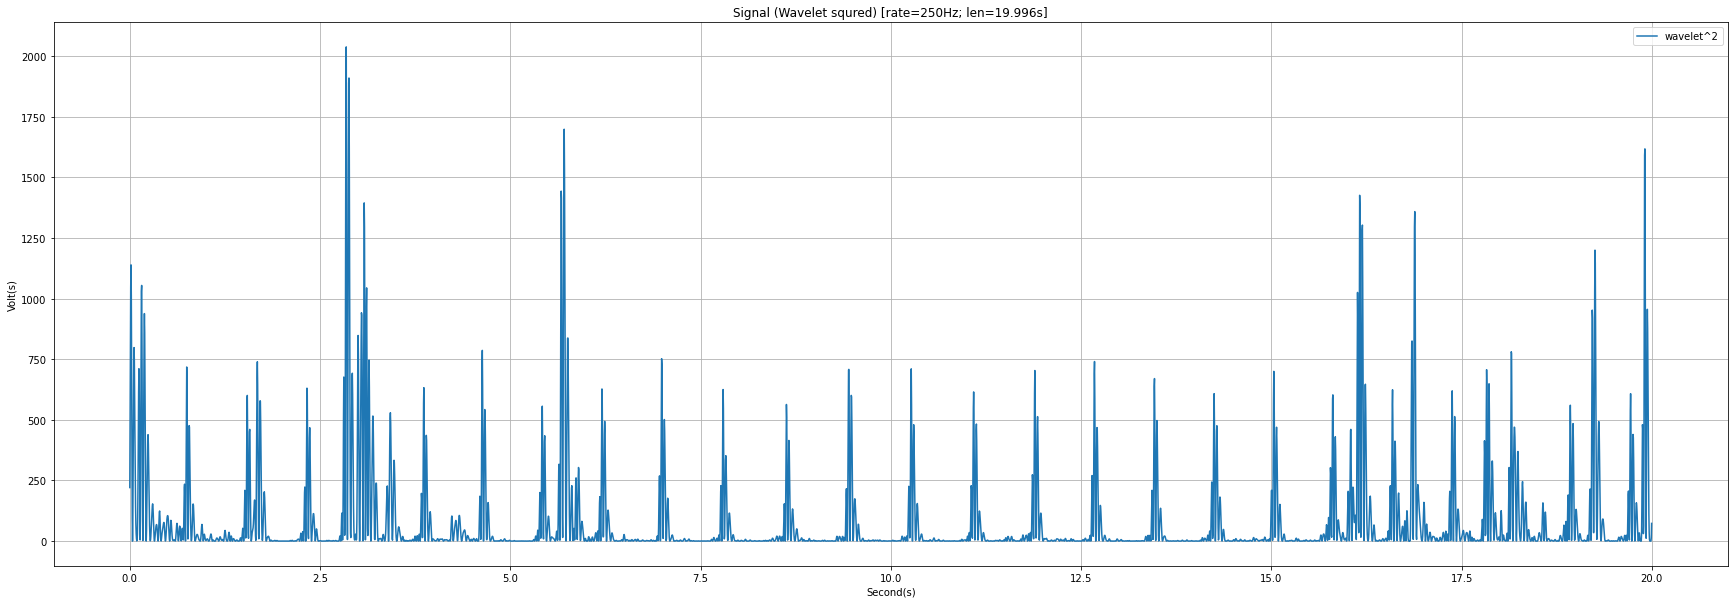

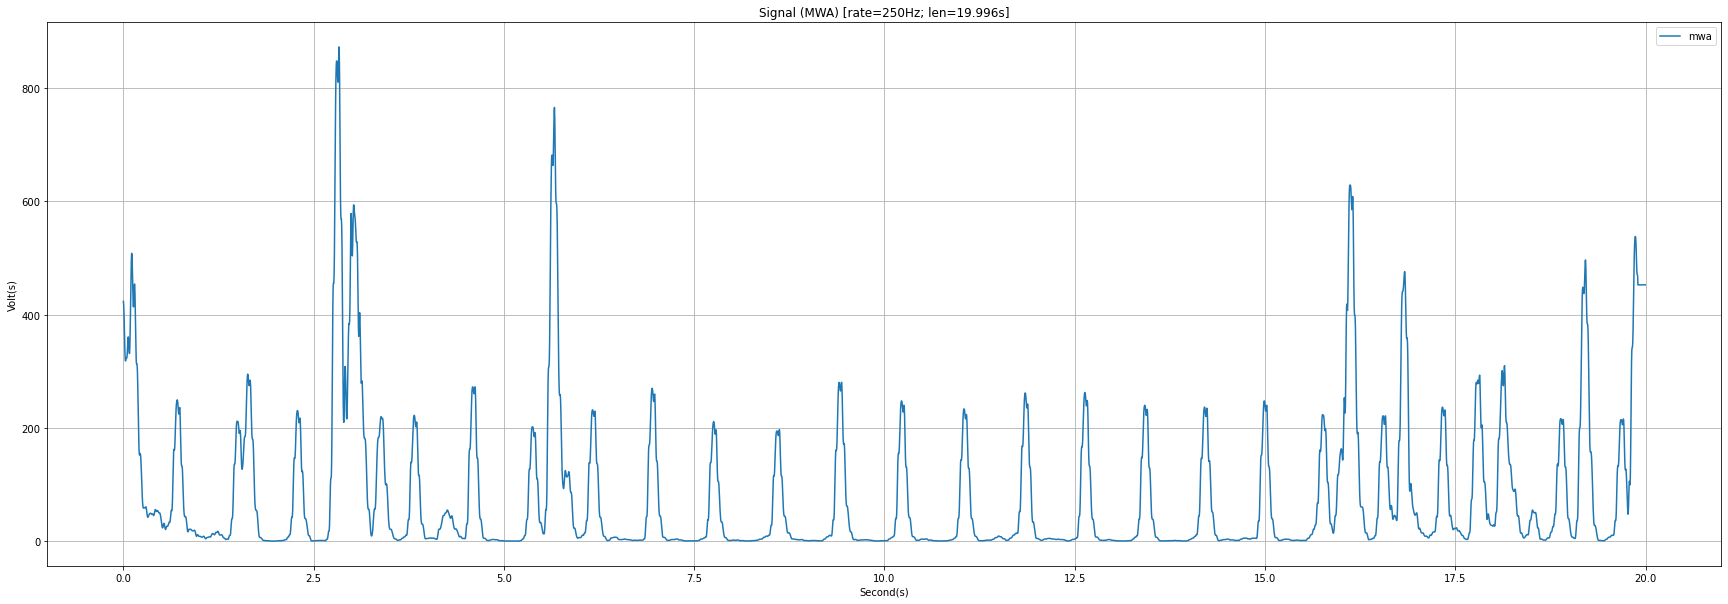

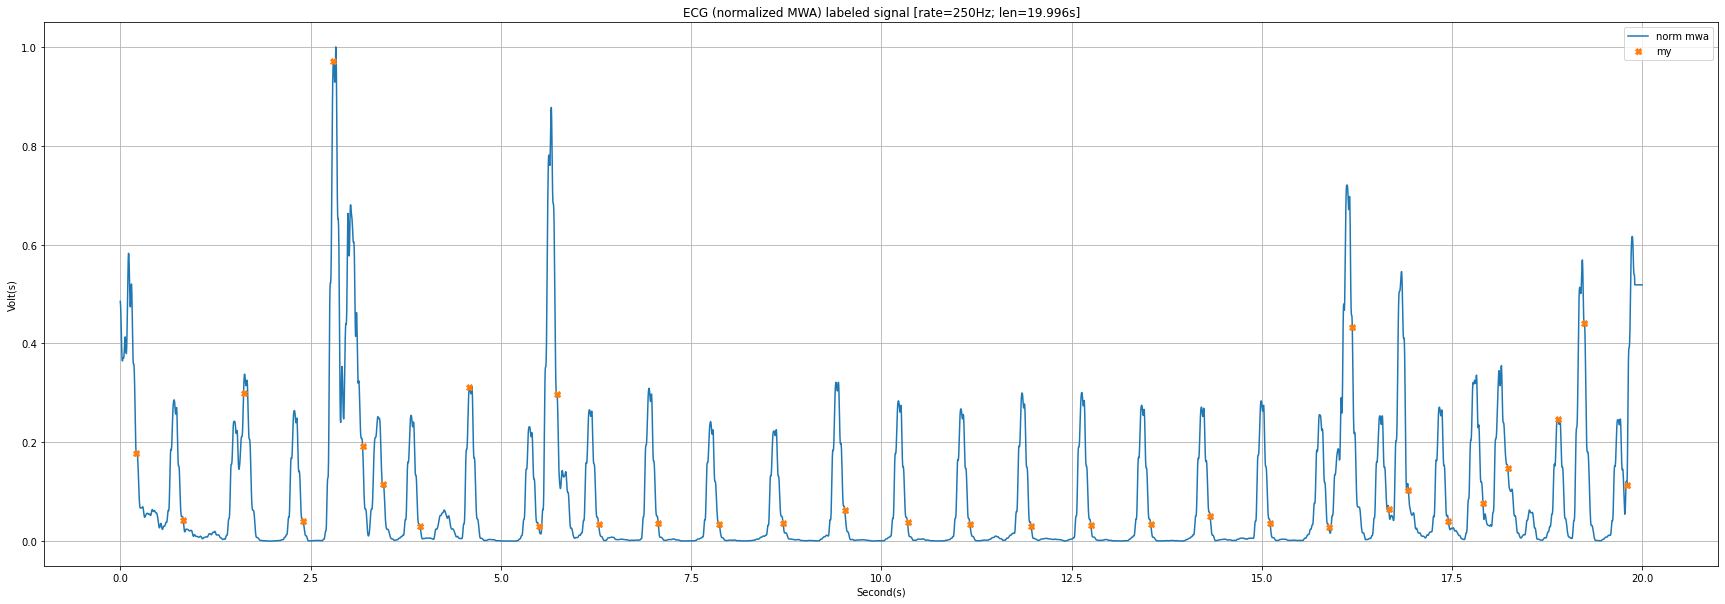

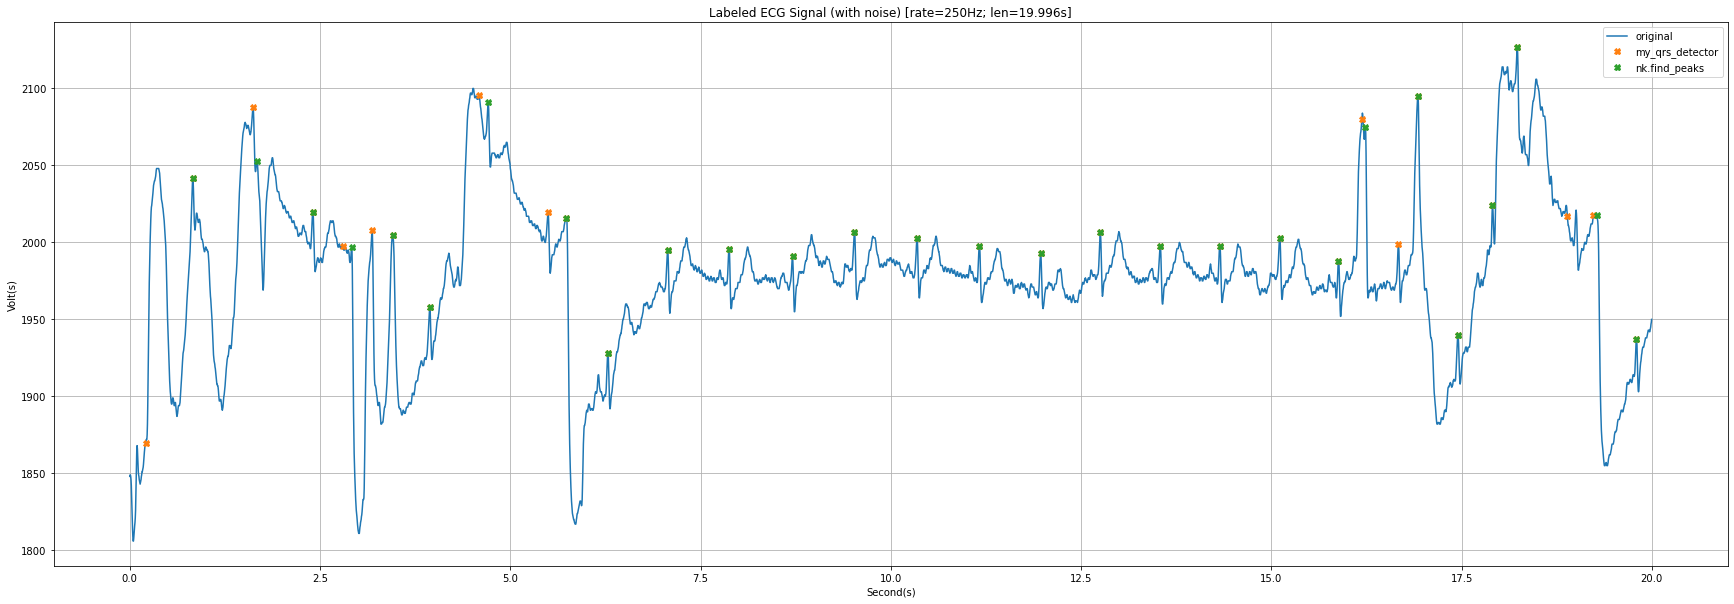

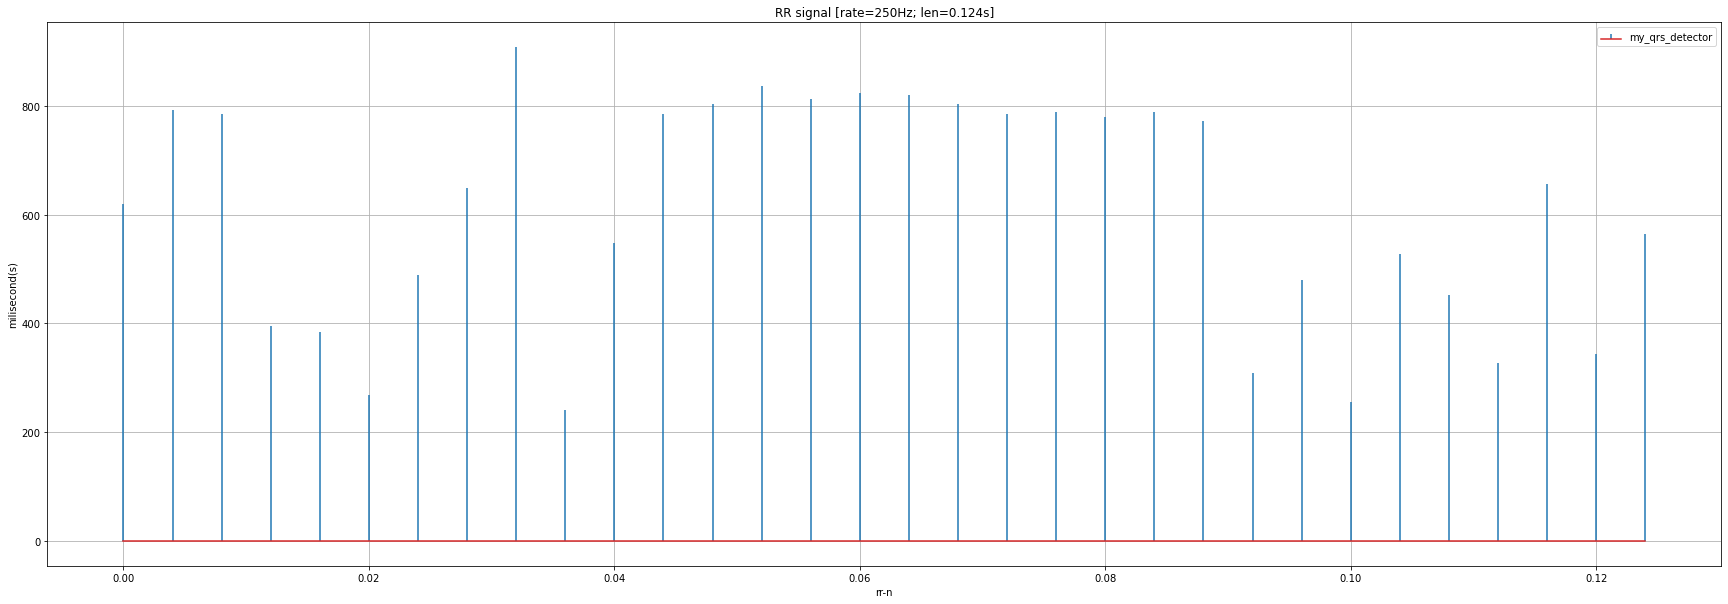

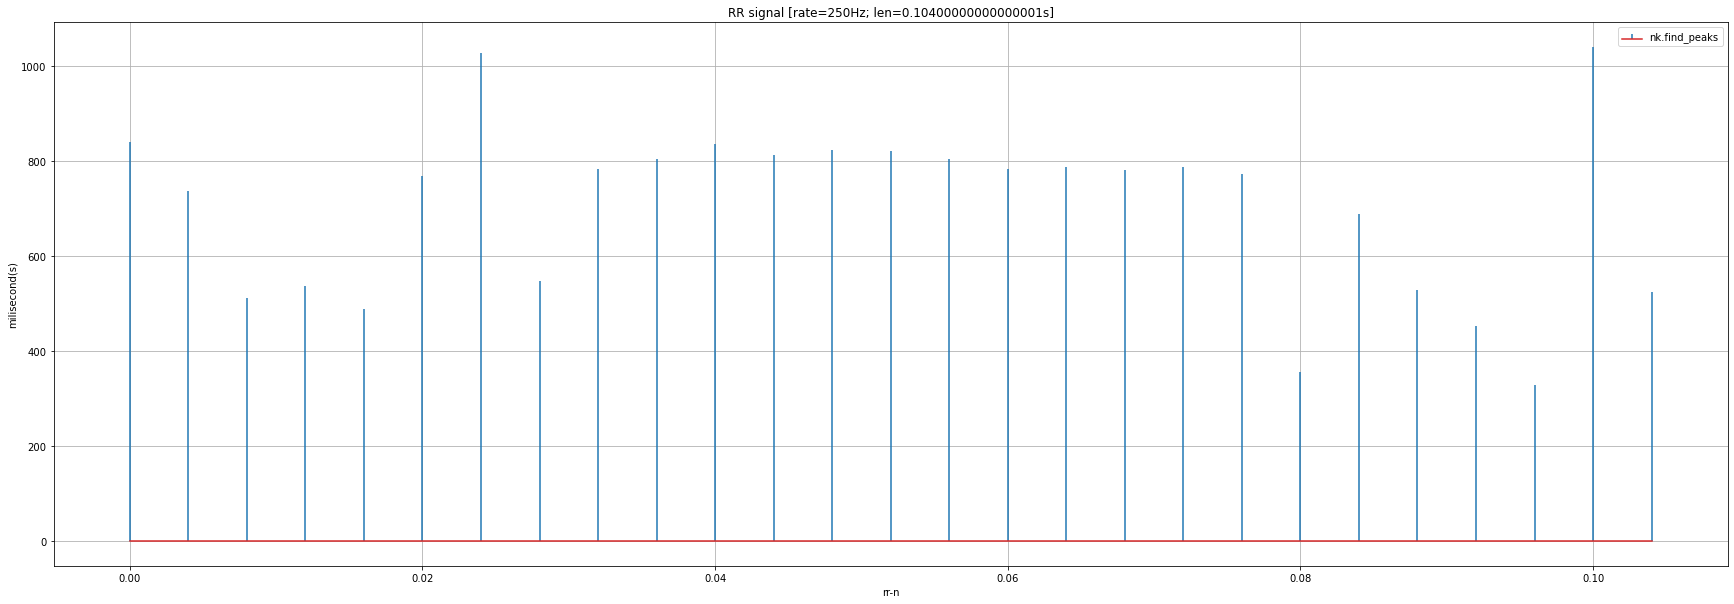

In [20]:
def demo(sig, fs, itv):
    start, end = itv[0]*fs, itv[1]*fs
    y = sig[start:end]
    
    my_peaks=my_swt_detector(y, fs, True)
    nk_peaks=nk.ecg_findpeaks(y, fs)["ECG_R_Peaks"]
    
    my_rr = (np.diff(my_peaks)/fs)*1000
    nk_rr = (np.diff(nk_peaks)/fs)*1000
    
    source_lbl = {
        "Labeled ECG Signal (with noise)": {
            "rate": fs,
            "y": pd.DataFrame(y, columns=["original"]),
            "labels": np.concatenate([np.array(['my_qrs_detector']*len(my_peaks)),np.array(['nk.find_peaks']*len(nk_peaks))]),
            "labels_ind": np.concatenate([np.array(my_peaks), np.array(nk_peaks)]),
        }
    }
    
    my_rr_sig = {
        "RR signal": {
            "rate": fs,
            "y": pd.DataFrame(my_rr, columns=["my_qrs_detector"])
        }
    }
    
    nk_rr_sig = {
        "RR signal": {
            "rate": fs,
            "y": pd.DataFrame(nk_rr, columns=["nk.find_peaks"])
        }
    }
    
    plot_signal(source_lbl, ("Second(s)", "Volt(s)"), size=(30, 10))
    plot_signal(my_rr_sig, ("rr-n", "milisecond(s)"), size=(30, 10), stem=True)
    plot_signal(nk_rr_sig, ("rr-n", "milisecond(s)"), size=(30, 10), stem=True)

demo(example, Hz, (6400, 6420))

In [17]:
def to_rr(fname, rate, start, ecg_col, rlen, lbl):
    start = rate*start*60 # start minute
    ecg = pd.read_csv(fname)[ecg_col][start:].to_numpy()
    print(f"{'='*10}\n"
          f"File: {fname}\n"
          f"Size: {ecg.size}")
    if (ecg.size) < rlen*rate:
        print("To small")
        return None
    peaks = []
    total_time = len(ecg)//rate
    step = 360
    peaks += my_swt_detector(ecg, rate)
    peaks=np.array(peaks)
    rr = (np.diff(peaks)/rate)*1000
    # drop last m rows, where size=n*rlen+m, m<rlen
    # space optimization
    rr = rr[:(rr.size//rlen)*rlen]\
            .reshape(-1, rlen)\
            .astype(np.uint16)
    rr_df = pd.DataFrame(rr, columns=map(str, range(0, rlen)))
    rr_df["lbl"] = lbl
    return rr_df

In [9]:
to_rr_healthy  = lambda fname: to_rr(fname, Hz, 2, "EcgWaveform", 180, 0)
to_rr_diabetes = lambda fname: to_rr(fname, Hz, 2, "EcgWaveform", 180, 1)

In [10]:
def iter_root(root, lst):
    for subs, dirs, fls in os.walk(root):
        for fl in fls:
            if fl.endswith(".csv"):
                lst+=[subs+os.sep+fl]
    return lst

In [11]:
def preprocess(root, rr_name, converter):
    df = pd.concat([ converter(fl) for fl in iter_root(root, []) ])
    df.to_csv(rr_name, index=False)
    return df

In [26]:
def load_dataset():
    ds = []
    for root, converter, rr_name in zip(
        [diabetes_root, healthy_root], 
        [to_rr_diabetes, to_rr_healthy], 
        [rr_diabetes_dataset, rr_healthy_dataset]
    ):
        if os.path.isfile(rr_name):
            print(f"{rr_name} -- Found")
            ds += [pd.read_csv(rr_name, index_col=None)]
        else:
            print(f"{rr_name} -- Missing")
            ds += [preprocess(root, rr_name, converter)]
    ds = pd.concat(ds)
    return dsRESCALING

In [ ]:
ds = load_dataset().sample(frac=1).reset_index(drop=True); ds

rr_diabetes.csv -- Missing
File: dataset/diabetes_subset_ecg_data/001/sensor_data/2014_10_01-10_09_39/2014_10_01-10_09_39_ECG.csv
Size: 10976750
=START=
=END=
File: dataset/diabetes_subset_ecg_data/001/sensor_data/2014_10_02-10_56_44/2014_10_02-10_56_44_ECG.csv
Size: 9635000
=START=


In [678]:
from scipy import stats
z_scores = stats.zscore(ds)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3.5).all(axis=1)
dataset_01 = ds[filtered_entries];dataset_01

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,lbl
0,584,548,556,524,548,468,504,500,504,512,...,528,564,468,492,508,524,452,524,500,0
3,648,776,772,756,108,652,728,728,620,756,...,632,108,636,108,644,108,620,108,620,0
5,872,108,908,108,872,124,880,1000,928,108,...,664,632,636,688,636,672,632,628,668,0
7,720,712,112,596,716,736,732,736,37084,112,...,112,680,112,680,796,792,764,768,824,0
8,760,732,700,696,736,852,932,888,780,784,...,960,37544,992,944,108,784,108,724,108,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36140,164,376,108,420,184,332,120,256,252,208,...,444,236,212,184,304,108,268,252,632,1
36141,828,824,800,812,792,768,732,720,700,692,...,688,108,792,904,884,868,852,112,752,1
36143,112,600,708,712,704,704,704,700,700,704,...,692,712,700,692,696,688,688,688,676,1
36146,108,628,120,624,124,612,108,616,108,624,...,744,732,744,760,756,756,740,708,692,0


In [679]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(ds.sample(frac=1).reset_index(drop=True), test_size=0.3)

In [680]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [696]:
model = keras.Sequential([
    keras.layers.Conv1D(64, 3, activation='relu', input_shape = (180, 1), padding='same'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling1D(3),
    keras.layers.Conv1D(512, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling1D(3),
    keras.layers.Conv1D(1024, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling1D(4),
    keras.layers.LSTM(70),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='linear'),
])

In [697]:
model.compile(optimizer='adam',
              loss='hinge',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 180, 64)           256       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 90, 64)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 90, 128)           24704     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 45, 128)           0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 45, 256)           98560     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 15, 256)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 15, 512)          

In [698]:
train_data, train_lbl = train_set.drop(['lbl'], axis=1), train_set['lbl']
test_data, test_lbl = test_set.drop(['lbl'], axis=1), test_set['lbl']

train_stats = train_data.describe()
train_stats = train_stats.transpose()
print(type(train_stats))

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_data)
normed_test_data = norm(test_data)

<class 'pandas.core.frame.DataFrame'>


In [699]:
np_train_data = normed_train_data.to_numpy()
np_train_lbls = train_lbl.to_numpy()
model.fit(np.expand_dims(np_train_data, -1), np_train_lbls, epochs=10, batch_size=32)

Epoch 1/10
791/791 [==============================] - 101s 125ms/step - loss: 0.6384 - accuracy: 0.6917
Epoch 2/10
791/791 [==============================] - 104s 131ms/step - loss: 0.5925 - accuracy: 0.7113
Epoch 3/10
791/791 [==============================] - 117s 148ms/step - loss: 0.5957 - accuracy: 0.7111
Epoch 4/10
791/791 [==============================] - 119s 151ms/step - loss: 0.5945 - accuracy: 0.7089
Epoch 5/10
791/791 [==============================] - 111s 140ms/step - loss: 0.5822 - accuracy: 0.7151
Epoch 6/10
791/791 [==============================] - 124s 156ms/step - loss: 0.5888 - accuracy: 0.7110
Epoch 7/10
791/791 [==============================] - 130s 163ms/step - loss: 0.5957 - accuracy: 0.7075
Epoch 8/10
791/791 [==============================] - 119s 151ms/step - loss: 0.5847 - accuracy: 0.7132
Epoch 9/10
791/791 [==============================] - 120s 152ms/step - loss: 0.5864 - accuracy: 0.7122
Epoch 10/10
791/791 [==============================] - 114s 144m

In [701]:
np_test_data = normed_test_data.to_numpy()
np_test_lbls = test_lbl.to_numpy()

loss, acc = model.evaluate(np.expand_dims(np_test_data, -1),  test_lbl, verbose=2)
print('Accuracy: ', acc)
print('Loss: ', loss)

339/339 - 13s - loss: 0.5792 - accuracy: 0.7135
Accuracy:  0.713534951210022
Loss:  0.5791746973991394
